# Basic Statistics Test on the Dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
from matplotlib.backends.backend_pdf import PdfPages

In [4]:
alldata = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/full_cleaned_data.csv')

In [5]:
alldata['Agree'] = ~(alldata['True_state']^alldata['Alert'])

In [6]:
alldata.head()

,Trial,True_state,Alert,Identification,First_toggle_time,RMS,Attention,Click,Agree
0,0,True,True,True,4179,65.244487,0.914573,2,True
1,1,False,False,False,3653,67.293907,0.895000,2,True
2,2,False,True,False,2186,100.119892,0.854271,2,False
3,3,False,False,False,3412,33.403009,0.889447,2,True
4,4,False,False,False,4514,70.063858,0.929648,2,True


In [7]:
abnormal = alldata[alldata['RMS']>50]
normal = alldata[alldata['RMS']<=50]

In [43]:
len(normal)-sum(normal['Identification'])

2534

In [45]:
sum(abnormal['Identification'])

88

Next We try logistic regression, the first and the most simple machine learning model for binary outcomes.

In [8]:
newdata = abnormal.append(normal.sample(n=347))

In [9]:
newdata['performance'] = newdata['RMS'] <= 50

In [10]:
X = newdata.drop(['RMS','performance','Click'],axis=1)
y = newdata['performance']

In [11]:
accuracy = []
auc = []

In [12]:
states = np.arange(0,30)

In [13]:
for state in states:
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.4, random_state=state,stratify=y)
    logreg = LogisticRegression()
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    accuracy.append(np.sum(y_pred==y_test)/len(y_pred))
    y_pred_prob = logreg.predict_proba(X_test)[:,1]
    auc.append(roc_auc_score(y_test,y_pred_prob))

In [14]:
np.mean(accuracy)

0.6345323741007193

In [15]:
np.median(accuracy)

0.6330935251798561

In [16]:
np.mean(auc)

0.6714300502044408

In [17]:
np.median(auc)

0.6658040474095543

In [96]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
y_pred = logreg.predict(X_test)

In [98]:
print(confusion_matrix(y_test, y_pred))

[[64 40]
 [42 63]]


In [99]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.60      0.62      0.61       104
       True       0.61      0.60      0.61       105

avg / total       0.61      0.61      0.61       209



In [18]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

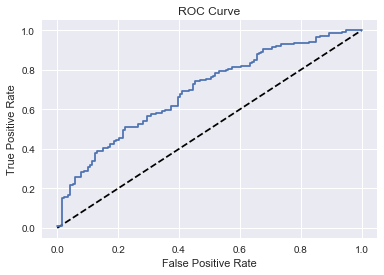

In [22]:
pp = PdfPages('Sample_ROC.pdf')
sns.set()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig(pp,format='pdf')
pp.close()

In [20]:
print("AUC: {}".format(roc_auc_score(y_test,y_pred_prob)))

AUC: 0.6932870969411521
